# Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model


# Loading Data 

In [2]:
# Load the CSV files
#augmented_df = pd.read_csv('dataset/csvs/augmented.csv')
df_augmented = pd.read_csv('dataset/csvs/augmented.csv')
test_df = pd.read_csv('dataset/csvs/test_df.csv')
val_df = pd.read_csv('dataset/csvs/val_df.csv')

# Creating Datasets 

In [3]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

In [4]:
def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


In [5]:
def load_and_prepare_aug_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Concatenate the directory with filenames to get the full image paths
    images = images_dir + df['filename'].astype(str)
    
    # Convert labels to the correct format if they are not already (e.g., one-hot encoding)
    # This step depends on how your labels are formatted and what your model expects
    labels = df['target'].values
    labels = np.array(labels)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(parse_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch data for performance
    
    return dataset


In [6]:
df_augmented['target'] = df_augmented['target'].apply(lambda x: str(x))


In [7]:
#train_ds = load_and_prepare_aug_dataset(augmented_df, 'dataset/augmented_images/', shuffle=True, batch_size=16)
train_ds = load_and_prepare_aug_dataset(df_augmented, 'dataset/augmented_images/', shuffle=True, batch_size=16)
val_ds = load_and_prepare_dataset(val_df, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=16)
test_ds = load_and_prepare_dataset(test_df, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=16)

In [8]:
print("size of training dataset: ", train_ds.cardinality().numpy())
print("size of validation dataset: ", val_ds.cardinality().numpy())
print("size of test dataset: ", test_ds.cardinality().numpy())

size of training dataset:  470
size of validation dataset:  128
size of test dataset:  160


# Loading and Visualising the Training Data 

Training dataset
(16, 224, 224, 3)
(16, 8)


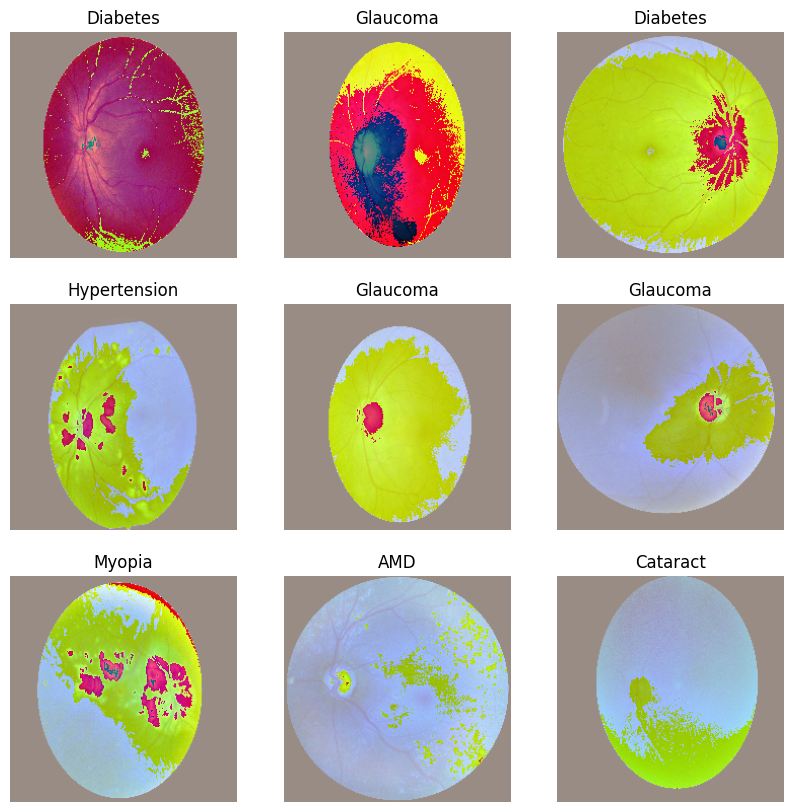

In [14]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")

Validation dataset
(16, 224, 224, 3)
(16, 8)


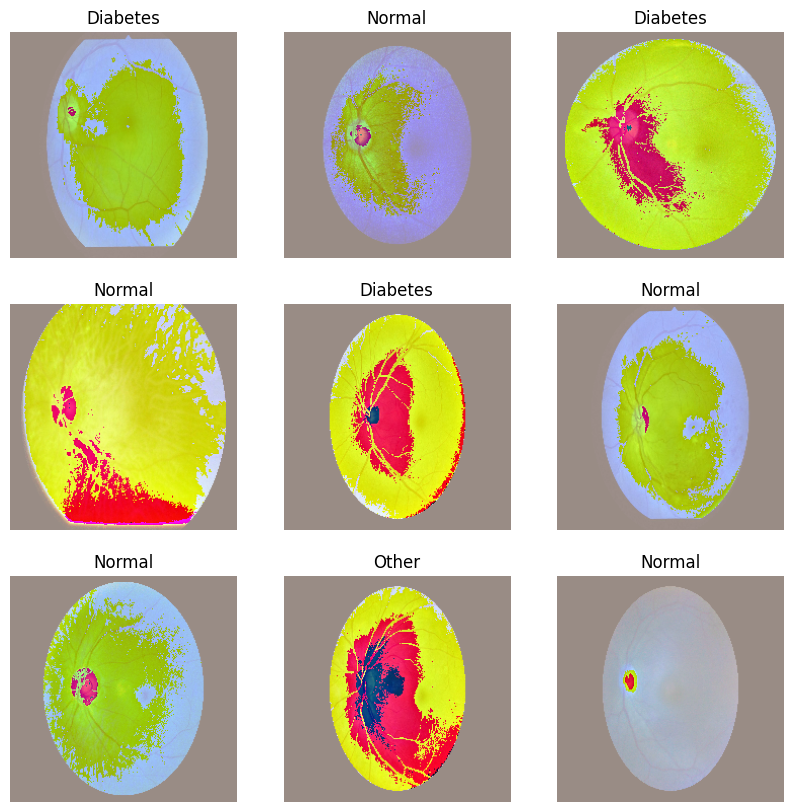

In [15]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

Class Weights Calculation

In [16]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Calculate class weights
class_weights = get_class_weights(train_labels)
print("Class weights:", class_weights)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)


Class weights: [1.04388889 1.04388889 1.03241758 1.00481283 0.92107843 1.04157428
 0.90076702 1.03697572]
Class weights dictionary: {0: 1.0438888888888889, 1: 1.0438888888888889, 2: 1.0324175824175825, 3: 1.004812834224599, 4: 0.921078431372549, 5: 1.0415742793791574, 6: 0.9007670182166826, 7: 1.0369757174392935}


# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [9]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model_Resnet50_AUG.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1) #  factor reduced from 0.5 to 0.2
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # increased from 5 to 10


callbacks = [checkpoint, reduce_lr, early_stopping]

In [10]:
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l1_l2

resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False
    
resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
resnet_50_model.add(Dropout(0.3))
#resnet_50_model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
#resnet_50_model.add(Dropout(0.3))
# Add additional layers if necessary
resnet_50_model.add(Dense(8, activation='softmax'))

In [11]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 23,851,016
Trainable params: 263,304
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
epochs =  50
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50
470/470 [==============================] - ETA: 0s - loss: 1.6632 - accuracy: 0.4117
Epoch 1: val_loss improved from inf to 1.83242, saving model to best_model_Resnet50_AUG.h5
470/470 [==============================] - 77s 83ms/step - loss: 1.6632 - accuracy: 0.4117 - val_loss: 1.8324 - val_accuracy: 0.2854 - lr: 1.0000e-04
Epoch 2/50
469/470 [============================>.] - ETA: 0s - loss: 1.3673 - accuracy: 0.5203
Epoch 2: val_loss improved from 1.83242 to 1.71773, saving model to best_model_Resnet50_AUG.h5
470/470 [==============================] - 65s 78ms/step - loss: 1.3673 - accuracy: 0.5204 - val_loss: 1.7177 - val_accuracy: 0.3592 - lr: 1.0000e-04
Epoch 3/50
469/470 [============================>.] - ETA: 0s - loss: 1.2653 - accuracy: 0.5589
Epoch 3: val_loss did not improve from 1.71773
470/470 [==============================] - 63s 76ms/step - loss: 1.2659 - accuracy: 0.5585 - val_loss: 1.8144 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 4/50
469/470 [=========

Finetuning

In [32]:
# After the initial training phase, start fine-tuning
# Gradually unfreeze the top layers of the pre-trained model
for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

# Re-compile the model to apply the change
resnet_50_model.compile(optimizer=Adam(learning_rate=0.00001),  # Use a lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model
history_fine = resnet_50_model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=45,  # Continue for the rest of the epochs
                         callbacks=callbacks)

Epoch 1/45
470/470 [==============================] - ETA: 0s - loss: 0.8672 - accuracy: 0.7912
Epoch 1: val_loss did not improve from 1.71456
470/470 [==============================] - 71s 83ms/step - loss: 0.8672 - accuracy: 0.7912 - val_loss: 1.7310 - val_accuracy: 0.4673 - lr: 1.0000e-05
Epoch 2/45
469/470 [============================>.] - ETA: 0s - loss: 0.8536 - accuracy: 0.7976
Epoch 2: val_loss did not improve from 1.71456
470/470 [==============================] - 67s 80ms/step - loss: 0.8539 - accuracy: 0.7974 - val_loss: 1.7742 - val_accuracy: 0.4526 - lr: 1.0000e-05
Epoch 3/45
469/470 [============================>.] - ETA: 0s - loss: 0.8398 - accuracy: 0.8034
Epoch 3: val_loss did not improve from 1.71456
470/470 [==============================] - 66s 82ms/step - loss: 0.8399 - accuracy: 0.8034 - val_loss: 1.7168 - val_accuracy: 0.4775 - lr: 1.0000e-05
Epoch 4/45
469/470 [============================>.] - ETA: 0s - loss: 0.8334 - accuracy: 0.8017
Epoch 4: val_loss did not

# Evaluating Model 

Model Accuracy Graph Analysis

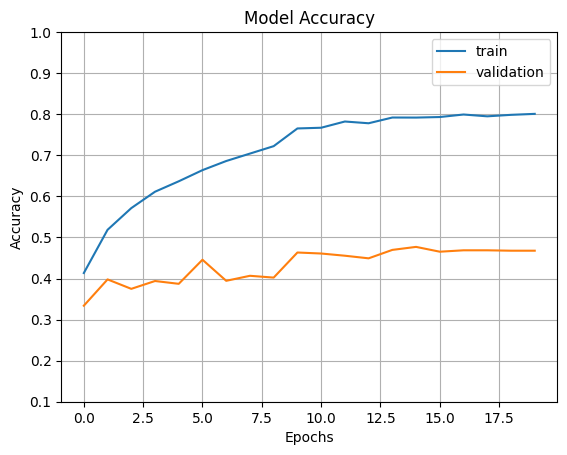

In [35]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

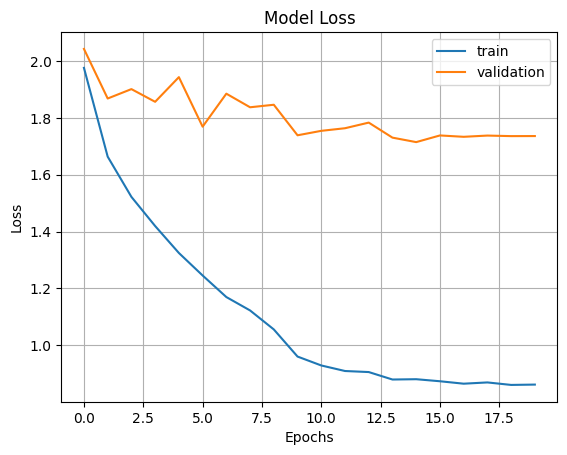

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

160/160 [==============================] - 11s 61ms/step - loss: 1.7146 - accuracy: 0.4926
Evaluation results: [1.7145730257034302, 0.4925723075866699]
160/160 [==============================] - 10s 58ms/step


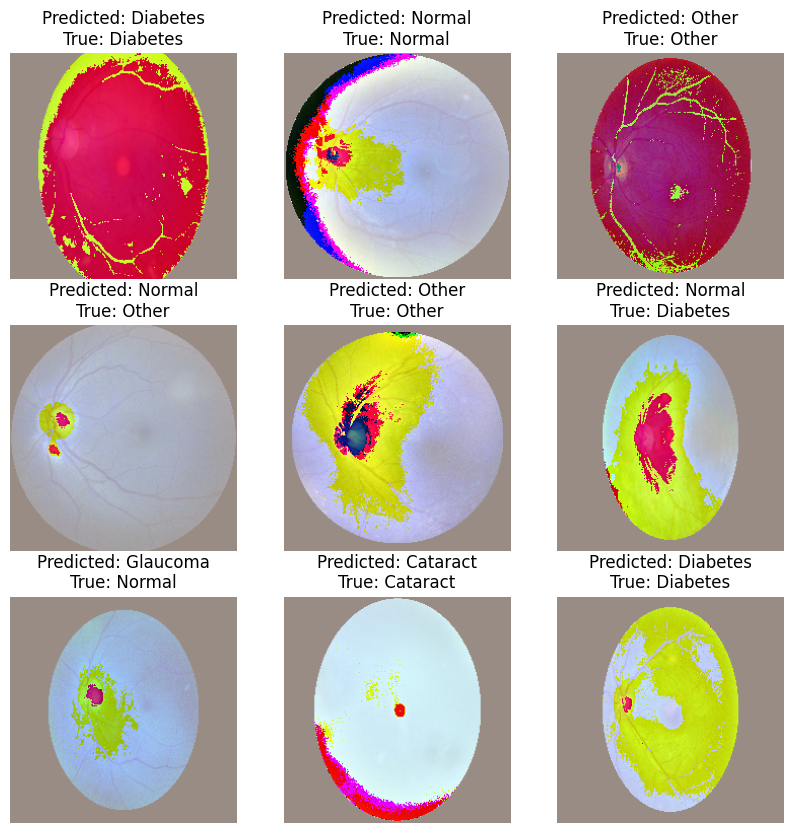

In [24]:
from tensorflow.keras.models import load_model

# Load the saved model
resnet_50_model = load_model('best_model_Resnet50_AUG.h5')

# Evaluate the model on the test dataset
evaluation_results = resnet_50_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = resnet_50_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Predictions Result Evaluation

In [25]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [26]:
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Shape of true_labels after vstack: (2558, 8)


In [27]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.62      0.50      0.55      1150
      Diabetes       0.47      0.53      0.50       644
      Glaucoma       0.30      0.49      0.38       114
      Cataract       0.53      0.80      0.64       118
           AMD       0.46      0.43      0.45       106
  Hypertension       0.23      0.30      0.26        50
        Myopia       0.67      0.85      0.75        92
Other diseases       0.22      0.20      0.21       284

      accuracy                           0.49      2558
     macro avg       0.44      0.51      0.47      2558
  weighted avg       0.51      0.49      0.49      2558



Balanced Accuracy Score 

In [28]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5124


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [29]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8068


Confusion Matrix 

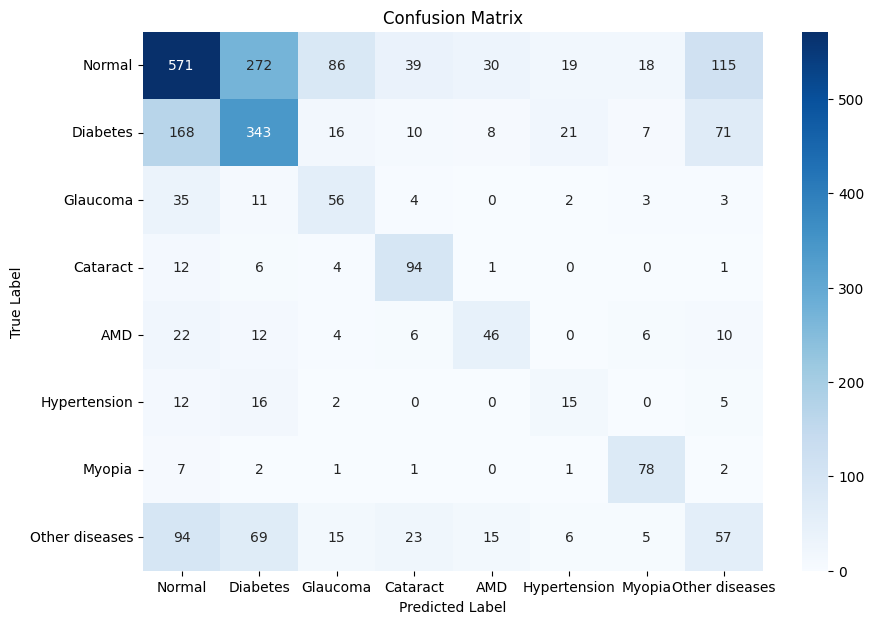

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

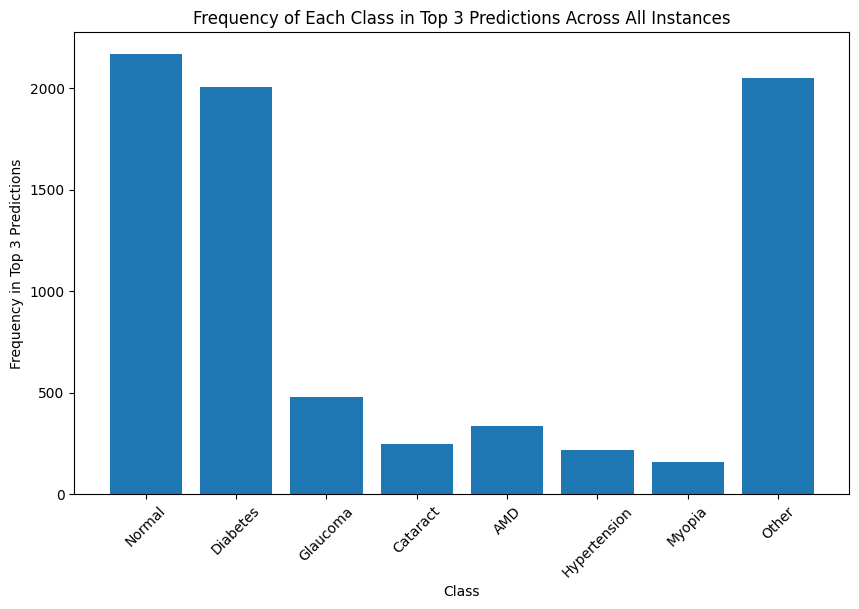

In [31]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()